YOLO Model Prediction and Evaluation Pipeline

This notebook implements the final phase of the YOLO object detection workflow. It loads the best-performing model from the training phase, executes inference on the test dataset, and generates comprehensive evaluation metrics including mean Average Precision (mAP), precision, recall, and per-class performance analysis.

Workflow:
1. Load trained YOLO model from file system
2. Execute batch inference on test images
3. Compute object detection metrics
4. Analyze per-class performance
5. Generate detection visualizations
6. Export results to MLflow

In [ ]:
import torch
import numpy as np
from pathlib import Path
from ultralytics import YOLO
from PIL import Image
import json

MODELS_DIR = Path('../models')
DATA_DIR = Path('../data')
BEST_MODEL_PATH = MODELS_DIR / 'yolo_run' / 'weights' / 'best.pt'

print("YOLO PREDICTION PIPELINE")
print("=" * 50)

if not BEST_MODEL_PATH.exists():
    print(f"Error: Model not found at {BEST_MODEL_PATH}")
    print("Execute notebook 02_train_yolo.ipynb first")
else:
    model = YOLO(str(BEST_MODEL_PATH))
    print(f"Model loaded: {BEST_MODEL_PATH}")
    print("=" * 50)

In [ ]:
test_dir = DATA_DIR / 'images' / 'test'
test_images = sorted(test_dir.glob('*.jpg'))

print(f"\nBatch Inference on {len(test_images)} test images")
print("-" * 50)

all_results = []
class_map = {0: 'person', 1: 'car', 2: 'dog'}

for img_path in test_images[:10]:
    results = model.predict(source=str(img_path), conf=0.5, verbose=False)
    result = results[0]
    
    detections_count = len(result.boxes) if result.boxes is not None else 0
    all_results.append({
        'image': img_path.name,
        'detections': detections_count,
        'boxes': result.boxes
    })
    
    print(f"{img_path.name}: {detections_count} detections")

print(f"\nProcessed {len(all_results)} images")
print("=" * 50)

In [ ]:
class_stats = {cls: {'count': 0, 'confidences': []} for cls in class_map.values()}

print("\nDetection Analysis")
print("-" * 50)

for result_data in all_results:
    if result_data['boxes'] is not None:
        for box in result_data['boxes']:
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = class_map.get(class_id, 'unknown')
            
            class_stats[class_name]['count'] += 1
            class_stats[class_name]['confidences'].append(confidence)

print("\nPer-Class Detection Statistics:")
for class_name, stats in class_stats.items():
    count = stats['count']
    if count > 0:
        avg_conf = np.mean(stats['confidences'])
        print(f"  {class_name}: {count} detections (avg confidence: {avg_conf:.3f})")
    else:
        print(f"  {class_name}: 0 detections")

print("\n" + "=" * 50)
print("Evaluation Complete")

# 04 - Model Evaluation & Prediction

Load best model from MLflow and evaluate performance.
Generate comprehensive metrics and predictions.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import mlflow
import mlflow.keras
from pathlib import Path
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    roc_auc_score, hamming_loss, accuracy_score
)
import json

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# MLflow configuration
MLFLOW_DIR = Path('../mlruns')
mlflow.set_tracking_uri(f'file:///{MLFLOW_DIR.absolute()}')

print(f'MLflow tracking URI: file:///{MLFLOW_DIR.absolute()}')

## Load Data & Classes

In [ ]:
# Load test data
data_path = Path('../data/voc2007/voc2007_multilabel.npz')
data = np.load(data_path, allow_pickle=True)

X_test = data['X_test'].astype('float32') / 255.0
y_test = data['y_test'].astype('float32')

# Load classes
with open(Path('../data/voc2007/classes.json'), 'r') as f:
    class_info = json.load(f)
    classes = class_info if isinstance(class_info, list) else class_info['classes']

print(f'Test set: {X_test.shape}')
print(f'Classes: {len(classes)}')
print(f'Classes: {classes}')

## Load Best Model from MLflow

In [ ]:
# Load best model from Model Registry (Production stage)
try:
    model = mlflow.keras.load_model('models:/voc2007_multilabel_model/Production')
    print(f'✓ Best model loaded from MLflow Model Registry (Production)')
except:
    # Fallback: Load from local directory
    model = keras.models.load_model(Path('../models/voc2007_model'))
    print(f'✓ Model loaded from local directory')

print(f'Model ready for inference')

## Generate Predictions

In [ ]:
# Generate probability predictions
y_pred_probs = model.predict(X_test, verbose=0)

print(f'Predictions shape: {y_pred_probs.shape}')
print(f'Probability range: [{y_pred_probs.min():.4f}, {y_pred_probs.max():.4f}]')

## Threshold Optimization

In [ ]:
# Find optimal threshold using F1-score
best_f1 = 0
best_threshold = 0.5

for threshold in np.arange(0.1, 1.0, 0.05):
    y_pred = (y_pred_probs >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Optimal threshold: {best_threshold:.2f}')
print(f'F1-score at threshold: {best_f1:.4f}')

## Generate Final Predictions

In [ ]:
# Apply optimal threshold
y_pred = (y_pred_probs >= best_threshold).astype(int)

print(f'Predictions generated with threshold: {best_threshold}')

## Comprehensive Evaluation

In [ ]:
print('\n' + '='*70)
print('COMPREHENSIVE MODEL EVALUATION')
print('='*70)

# Microaveraged metrics (sample-wise)
print('\n[1] MICROAVERAGED METRICS (Sample-wise)')
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
auc_micro = roc_auc_score(y_test, y_pred_probs, average='micro')

print(f'  F1-Score:  {f1_micro:.4f}')
print(f'  Precision: {precision_micro:.4f}')
print(f'  Recall:    {recall_micro:.4f}')
print(f'  AUC:       {auc_micro:.4f}')

# Macroaveraged metrics (class-wise)
print('\n[2] MACROAVERAGED METRICS (Class-wise)')
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
auc_macro = roc_auc_score(y_test, y_pred_probs, average='macro')

print(f'  F1-Score:  {f1_macro:.4f}')
print(f'  Precision: {precision_macro:.4f}')
print(f'  Recall:    {recall_macro:.4f}')
print(f'  AUC:       {auc_macro:.4f}')

# Weighted average
print('\n[3] WEIGHTED AVERAGE METRICS')
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
auc_weighted = roc_auc_score(y_test, y_pred_probs, average='weighted')

print(f'  F1-Score:  {f1_weighted:.4f}')
print(f'  Precision: {precision_weighted:.4f}')
print(f'  Recall:    {recall_weighted:.4f}')
print(f'  AUC:       {auc_weighted:.4f}')

# Overall metrics
print('\n[4] OVERALL METRICS')
hamming = hamming_loss(y_test, y_pred)
exact_match = accuracy_score(y_test, y_pred)

print(f'  Hamming Loss:  {hamming:.4f}')
print(f'  Exact Match:   {exact_match:.4f}')

print('\n' + '='*70)

## Per-Class Analysis

In [ ]:
print('\n[5] PER-CLASS METRICS\n')

class_metrics = []
for i, class_name in enumerate(classes):
    f1 = f1_score(y_test[:, i], y_pred[:, i], zero_division=0)
    prec = precision_score(y_test[:, i], y_pred[:, i], zero_division=0)
    rec = recall_score(y_test[:, i], y_pred[:, i], zero_division=0)
    
    class_metrics.append({
        'class': class_name,
        'f1': f1,
        'precision': prec,
        'recall': rec
    })
    
    print(f'  {class_name:20s} | F1: {f1:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}')

print('\n' + '='*70)

## Sample Predictions

In [ ]:
# Find correct and incorrect predictions
correct_mask = (y_test == y_pred).all(axis=1)
incorrect_mask = ~correct_mask

correct_indices = np.where(correct_mask)[0]
incorrect_indices = np.where(incorrect_mask)[0]

print(f'\n[6] PREDICTION SAMPLES')
print(f'\nCorrect predictions: {len(correct_indices)}/{len(y_test)} ({len(correct_indices)/len(y_test)*100:.1f}%)')
print(f'Incorrect predictions: {len(incorrect_indices)}/{len(y_test)} ({len(incorrect_indices)/len(y_test)*100:.1f}%)')

# Sample correct prediction
if len(correct_indices) > 0:
    idx = correct_indices[0]
    true_labels = [classes[i] for i in np.where(y_test[idx])[0]]
    print(f'\nExample CORRECT prediction:')
    print(f'  True labels: {true_labels}')
    print(f'  Predicted: {true_labels}')

# Sample incorrect prediction
if len(incorrect_indices) > 0:
    idx = incorrect_indices[0]
    true_labels = [classes[i] for i in np.where(y_test[idx])[0]]
    pred_labels = [classes[i] for i in np.where(y_pred[idx])[0]]
    print(f'\nExample INCORRECT prediction:')
    print(f'  True labels: {true_labels}')
    print(f'  Predicted: {pred_labels}')

## Summary

In [ ]:
print('\n' + '='*70)
print('EVALUATION SUMMARY')
print('='*70)

summary = {
    'test_samples': len(y_test),
    'num_classes': len(classes),
    'threshold': best_threshold,
    'f1_micro': float(f1_micro),
    'f1_macro': float(f1_macro),
    'f1_weighted': float(f1_weighted),
    'precision_micro': float(precision_micro),
    'recall_micro': float(recall_micro),
    'auc_micro': float(auc_micro),
    'hamming_loss': float(hamming),
    'exact_match': float(exact_match),
    'correct_predictions': int(len(correct_indices)),
    'incorrect_predictions': int(len(incorrect_indices))
}

print('\nKey Metrics:')
for key, value in summary.items():
    if isinstance(value, float):
        print(f'  {key}: {value:.4f}')
    else:
        print(f'  {key}: {value}')

print('\n✅ Model evaluation complete')

# Prediccion - PASCAL VOC 2007 Multilabel

## Objetivo
Cargar el modelo y realizar predicciones multilabel REALES sobre objetos.

Ejemplos: persona + carro + perro, etc.

---
## 1. Importación de Librerías

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from PIL import Image
from io import BytesIO
import requests
import warnings
warnings.filterwarnings('ignore')

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

print(f" TensorFlow version: {tf.__version__}")

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

 TensorFlow version: 2.20.0


---
## 2. Configuración y Rutas

In [2]:
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / 'data' / 'voc2007'
MODELS_DIR = PROJECT_ROOT / 'models'
TEST_IMAGES_DIR = PROJECT_ROOT / 'data' / 'test_images'
TEST_IMAGES_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE = (224, 224)
DEFAULT_THRESHOLD = 0.5

print(f"Configuracion para PASCAL VOC 2007")
print(f"Datos: {DATA_DIR}")
print(f"Modelos: {MODELS_DIR}")
print(f"Test images: {TEST_IMAGES_DIR}")

Configuracion para PASCAL VOC 2007
Datos: c:\Users\mlata\Documents\iajordy2\data\voc2007
Modelos: c:\Users\mlata\Documents\iajordy2\models
Test images: c:\Users\mlata\Documents\iajordy2\data\test_images


---
## 3. Cargar Modelo Entrenado

In [3]:
# Definir loss personalizada para carga del modelo
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    """
    Focal Loss para multilabel (debe coincidir con el entrenamiento).
    """
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    focal_weight = tf.pow(1 - p_t, gamma)
    focal_bce = focal_weight * bce
    return tf.reduce_mean(focal_bce)

# Cargar modelo final con custom_objects
preferred_model = MODELS_DIR / 'voc_multilabel_final.h5'
legacy_model = MODELS_DIR / 'food_multilabel_final.h5'

if preferred_model.exists():
    model_path = preferred_model
elif legacy_model.exists():
    model_path = legacy_model
else:
    model_path = preferred_model

if model_path.exists():
    model = keras.models.load_model(
        model_path,
        custom_objects={'focal_loss': focal_loss},
        compile=False  # No compilar, solo cargar pesos
    )
    print(f" Modelo cargado desde: {model_path}")
else:
    print(f" Modelo no encontrado en: {model_path}")
    print("   Ejecuta primero el notebook 03_training_real_images.ipynb")
    raise FileNotFoundError(f"Modelo no encontrado en {model_path}")

# Verificar arquitectura
print(f"\n Información del modelo:")
print(f"   Input shape: {model.input_shape}")
print(f"   Output shape: {model.output_shape}")
print(f"   Número de clases: {model.output_shape[1]}")

 Modelo cargado desde: c:\Users\mlata\Documents\iajordy2\models\voc_multilabel_final.h5

 Información del modelo:
   Input shape: (None, 224, 224, 3)
   Output shape: (None, 20)
   Número de clases: 20


---
## 4. Cargar Clases y Configuración

In [4]:
# Cargar clases
with open(DATA_DIR / 'classes.json', 'r') as f:
    classes = json.load(f)

NUM_CLASSES = len(classes)

print(f"Clases cargadas: {NUM_CLASSES}")
print(f"Ejemplos: {classes[:10]}")

Clases cargadas: 20
Ejemplos: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow']


---
## 5. Función de Preprocesamiento de Imágenes

In [5]:
def preprocess_image(img_input, target_size=(224, 224)):
    """
    Preprocesa imagen desde archivo local, URL o array numpy.
    """
    if isinstance(img_input, str):
        if img_input.startswith('http'):
            # Descargar desde URL
            response = requests.get(img_input, timeout=10)
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            # Cargar desde archivo local
            img = Image.open(img_input).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img, dtype=np.float32) / 255.0
    elif isinstance(img_input, np.ndarray):
        if img_input.ndim == 4:
            return img_input
        img = Image.fromarray(img_input.astype('uint8')).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img, dtype=np.float32) / 255.0
    else:
        raise ValueError("img_input debe ser ruta, URL o array numpy")
    
    return np.expand_dims(img_array, axis=0)

print("Funcion de preprocesamiento definida (soporta URLs y archivos locales)")

Funcion de preprocesamiento definida (soporta URLs y archivos locales)


---
## 6. Función de Predicción Multilabel

In [6]:
def predict_multilabel(model, img_input, classes, threshold=0.5, top_k=None):
    """
    Realiza predicción multilabel sobre una imagen.
    
    Args:
        model: Modelo de Keras entrenado
        img_input: Ruta a imagen o array preprocesado
        classes: Lista de nombres de clases
        threshold: Umbral de probabilidad para considerar una clase
        top_k: Número máximo de clases a devolver (None = todas)
    
    Returns:
        Dict con labels, probabilidades y predicción binaria
    """
    # Preprocesar si es necesario
    if not isinstance(img_input, np.ndarray) or img_input.ndim != 4:
        img_array = preprocess_image(img_input)
    else:
        img_array = img_input
    
    # Predicción (probabilidades sigmoid)
    predictions = model.predict(img_array, verbose=0)[0]
    
    # Aplicar threshold
    binary_predictions = (predictions >= threshold).astype(int)
    
    # Obtener índices de clases predichas
    predicted_indices = np.where(binary_predictions == 1)[0]
    
    # Crear lista de resultados
    results = []
    for idx in predicted_indices:
        results.append({
            'class': classes[idx],
            'probability': float(predictions[idx])
        })
    
    # Ordenar por probabilidad (mayor a menor)
    results = sorted(results, key=lambda x: x['probability'], reverse=True)
    
    # Limitar a top_k si se especifica
    if top_k is not None:
        results = results[:top_k]
    
    # También devolver todas las probabilidades para análisis
    all_predictions = [
        {'class': classes[i], 'probability': float(predictions[i])}
        for i in range(len(classes))
    ]
    all_predictions = sorted(all_predictions, key=lambda x: x['probability'], reverse=True)
    
    return {
        'predicted_labels': [r['class'] for r in results],
        'predictions': results,
        'all_predictions': all_predictions,
        'num_labels': len(results),
        'threshold': threshold
    }

print(" Función de predicción definida")

 Función de predicción definida


---
## 7. Función de Visualización de Predicciones

In [7]:
def visualize_prediction(img_input, prediction_result, figsize=(14, 6)):
    """
    Visualiza una imagen con sus predicciones multilabel.
    
    Args:
        img_input: Ruta a la imagen o array
        prediction_result: Resultado de predict_multilabel()
        figsize: Tamaño de la figura
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Cargar imagen para visualización
    if isinstance(img_input, (str, Path)):
        img = Image.open(img_input)
    elif isinstance(img_input, np.ndarray):
        if img_input.ndim == 4:
            img = Image.fromarray(img_input[0].astype('uint8'))
        else:
            img = Image.fromarray(img_input.astype('uint8'))
    
    # Subplot 1: Imagen
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Imagen de Entrada', fontsize=14, fontweight='bold')
    
    # Subplot 2: Predicciones
    predictions = prediction_result['predictions'][:10]  # Top 10
    
    if len(predictions) > 0:
        labels = [p['class'] for p in predictions]
        probs = [p['probability'] for p in predictions]
        
        # Colores: verde para predicho, amarillo para probabilidad media
        colors = ['green' if p >= prediction_result['threshold'] else 'orange' 
                  for p in probs]
        
        y_pos = np.arange(len(labels))
        axes[1].barh(y_pos, probs, color=colors, edgecolor='black')
        axes[1].set_yticks(y_pos)
        axes[1].set_yticklabels(labels)
        axes[1].invert_yaxis()
        axes[1].set_xlabel('Probabilidad', fontsize=12)
        axes[1].set_title('Top Predicciones Multilabel', fontsize=14, fontweight='bold')
        axes[1].axvline(x=prediction_result['threshold'], color='red', 
                        linestyle='--', linewidth=2, label=f"Threshold={prediction_result['threshold']}")
        axes[1].legend()
        axes[1].grid(axis='x', alpha=0.3)
        axes[1].set_xlim([0, 1])
    else:
        axes[1].text(0.5, 0.5, 'No se detectaron etiquetas\ncon el threshold actual', 
                     ha='center', va='center', fontsize=12)
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir resumen
    print(f"\n RESULTADO DE PREDICCIÓN\n")
    print(f"{'='*60}")
    print(f"Threshold utilizado: {prediction_result['threshold']}")
    print(f"Número de etiquetas detectadas: {prediction_result['num_labels']}")
    print(f"\n Etiquetas predichas:")
    if prediction_result['num_labels'] > 0:
        for pred in prediction_result['predictions']:
            print(f"   • {pred['class']}: {pred['probability']:.4f} ({pred['probability']*100:.2f}%)")
    else:
        print("   (Ninguna)")
    print(f"{'='*60}")

print(" Función de visualización definida")

 Función de visualización definida


---
## 8. Prediccion con Imagenes de Prueba

Test images preparadas: (10, 224, 224, 3)
Seleccionadas imagenes con multilabel real
Predicciones realizadas


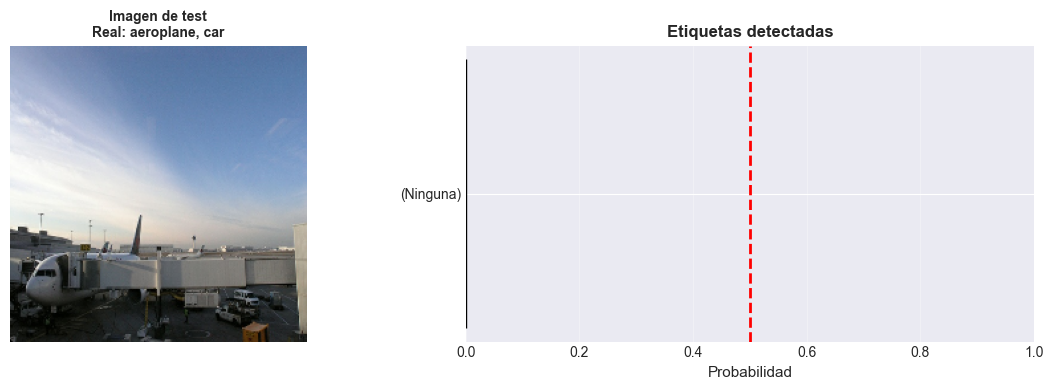

Imagen 1:
  Real: aeroplane, car
  Predicho: (Ninguna)



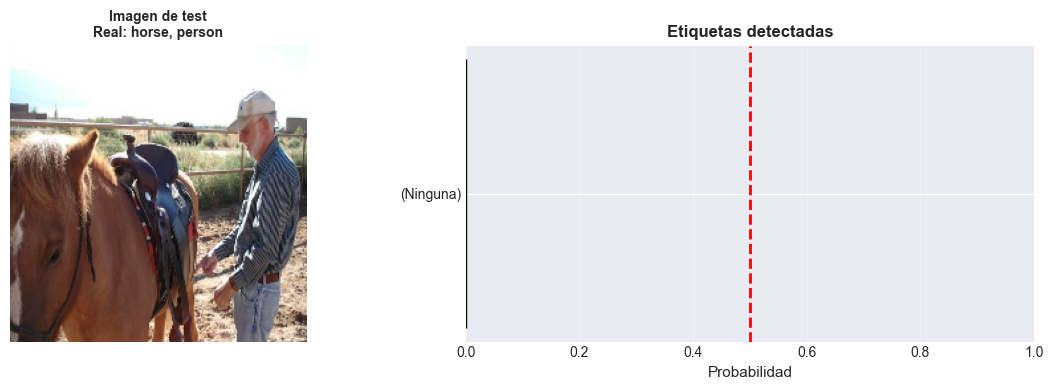

Imagen 2:
  Real: horse, person
  Predicho: (Ninguna)



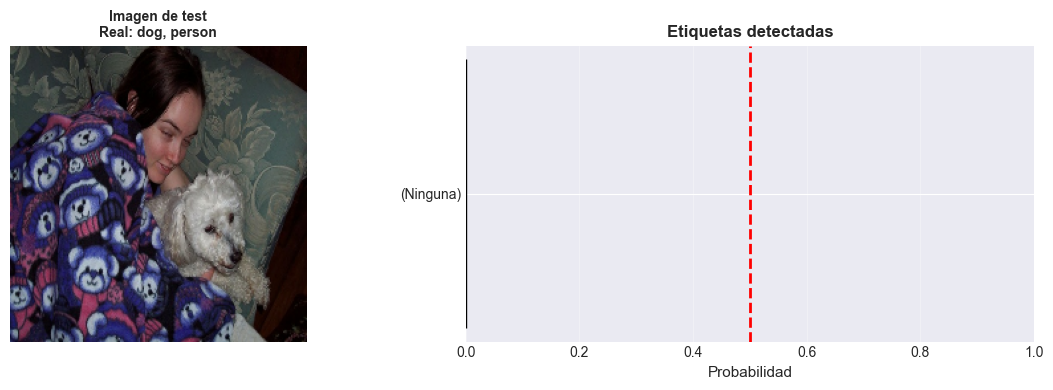

Imagen 3:
  Real: dog, person
  Predicho: (Ninguna)



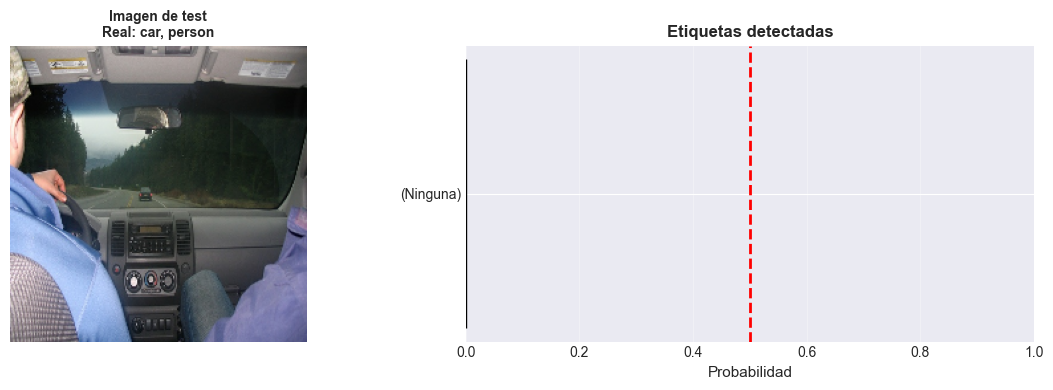

Imagen 4:
  Real: car, person
  Predicho: (Ninguna)



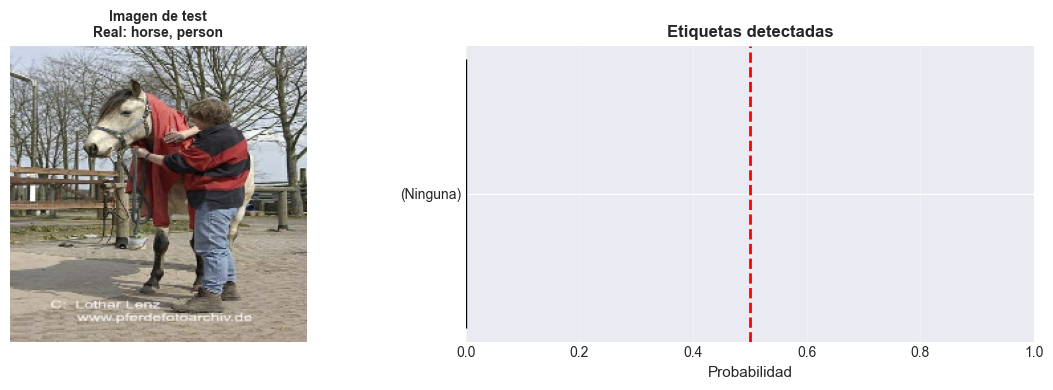

Imagen 5:
  Real: horse, person
  Predicho: (Ninguna)



In [8]:
# Cargar imagenes de test desde PASCAL VOC (NPZ)
npz_file = DATA_DIR / 'voc2007_multilabel.npz'
if not npz_file.exists():
    raise FileNotFoundError(f"No se encuentra {npz_file}. Ejecuta primero 01_data_analysis.ipynb")

data = np.load(npz_file, allow_pickle=True)
test_images_all = data['images']
test_labels_all = data['labels']

# Tomar imagenes con multiples categorias (multilabel real)
multilabel_mask = test_labels_all.sum(axis=1) >= 2
multilabel_indices = np.where(multilabel_mask)[0]

if len(multilabel_indices) >= 10:
    # Tomar imagenes multilabel
    test_indices = np.random.choice(multilabel_indices, size=10, replace=False)
else:
    # Tomar aleatorias
    test_indices = np.random.choice(len(test_images_all), size=10, replace=False)

test_images = test_images_all[test_indices]
test_labels = test_labels_all[test_indices]

# Normalizar
if test_images.max() > 1.0:
    test_images = test_images.astype(np.float32) / 255.0

print(f"Test images preparadas: {test_images.shape}")
print(f"Seleccionadas imagenes con multilabel real")

# Realizar predicciones
y_pred_probs = model.predict(test_images, verbose=0)

print(f"Predicciones realizadas")

# Visualizar resultados
for i in range(min(5, len(test_images))):
    pred_threshold = y_pred_probs[i] >= DEFAULT_THRESHOLD
    pred_labels = np.where(pred_threshold)[0]
    pred_label_names = [classes[idx] for idx in pred_labels]
    pred_probs = y_pred_probs[i][pred_threshold]
    
    # Etiquetas verdaderas
    true_labels = np.where(test_labels[i] == 1)[0]
    true_label_names = [classes[idx] for idx in true_labels]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    img = test_images[i]
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title(f'Imagen de test\nReal: {", ".join(true_label_names)}', fontsize=10, fontweight='bold')

    if len(pred_label_names) > 0:
        labels = pred_label_names
        probs = pred_probs
        colors = ['green'] * len(labels)
    else:
        labels = ['(Ninguna)']
        probs = [0]
        colors = ['gray']
    
    axes[1].barh(labels, probs, color=colors, edgecolor='black')
    axes[1].set_xlim([0, 1])
    axes[1].set_xlabel('Probabilidad', fontsize=11)
    axes[1].set_title('Etiquetas detectadas', fontsize=12, fontweight='bold')
    axes[1].axvline(x=DEFAULT_THRESHOLD, color='red', linestyle='--', linewidth=2)
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    print(f"Imagen {i+1}:")
    print(f"  Real: {', '.join(true_label_names)}")
    print(f"  Predicho: {', '.join(pred_label_names) if pred_label_names else '(Ninguna)'}")
    print()

---
## 9. Predicción con Diferentes Thresholds

###  Importancia del Threshold:
El threshold determina cuándo una probabilidad se convierte en una predicción positiva.

- **Threshold bajo (0.3)**: Más etiquetas, mayor recall, menor precisión
- **Threshold medio (0.5)**: Balance entre precisión y recall
- **Threshold alto (0.7)**: Menos etiquetas, mayor precisión, menor recall

In [9]:
# Comparar diferentes thresholds usando la primera imagen de test_images
thresholds = [0.3, 0.5, 0.7]

# Usar la primera imagen del batch de test obtenido antes
sample_image = test_images[0]

print(" Comparación de Thresholds\n")
print("="*80)

threshold_results = {}
for thresh in thresholds:
    result = predict_multilabel(
        model=model,
        img_input=sample_image,
        classes=classes,
        threshold=thresh
    )
    threshold_results[thresh] = result
    
    print(f"\nThreshold: {thresh}")
    print(f"  Etiquetas detectadas: {result['num_labels']}")
    print(f"  Labels: {', '.join(result['predicted_labels'][:5])}...")

print("\n" + "="*80)

 Comparación de Thresholds


Threshold: 0.3
  Etiquetas detectadas: 2
  Labels: person, car...

Threshold: 0.5
  Etiquetas detectadas: 0
  Labels: ...

Threshold: 0.7
  Etiquetas detectadas: 0
  Labels: ...



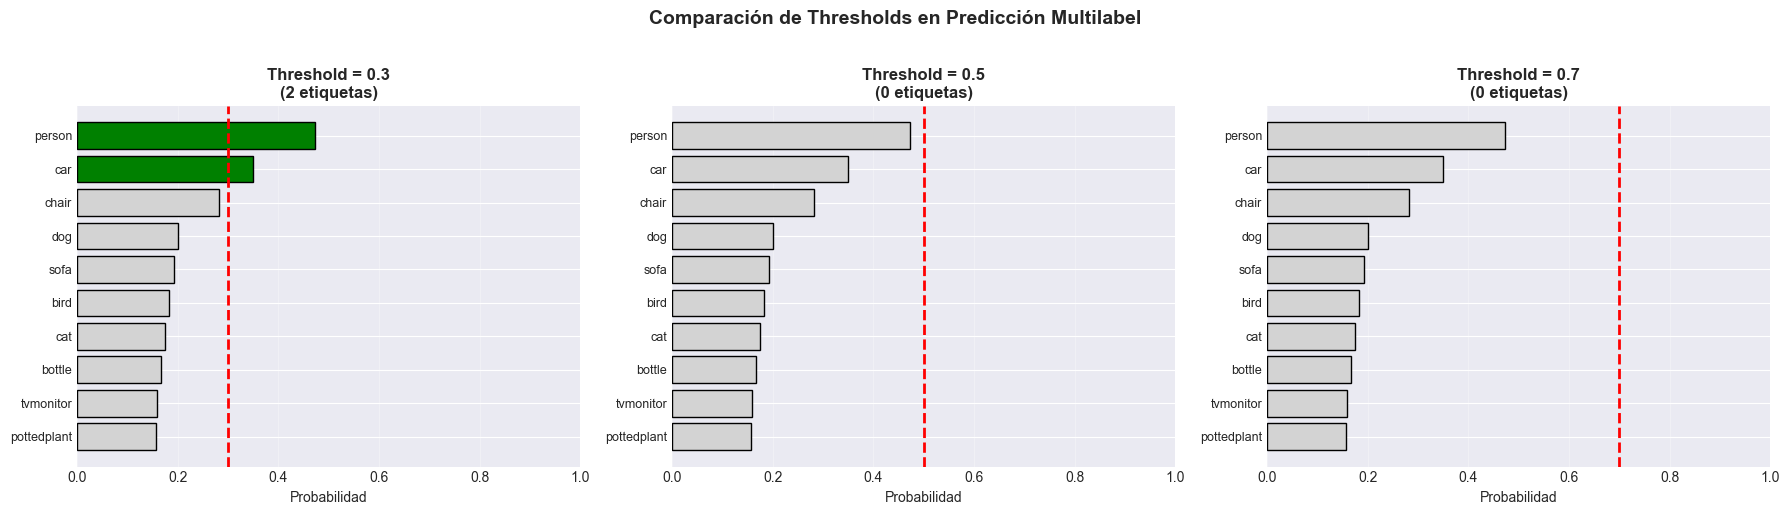

In [10]:
# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, thresh in enumerate(thresholds):
    result = threshold_results[thresh]
    predictions = result['all_predictions'][:10]
    
    labels = [p['class'] for p in predictions]
    probs = [p['probability'] for p in predictions]
    colors = ['green' if p >= thresh else 'lightgray' for p in probs]
    
    y_pos = np.arange(len(labels))
    axes[idx].barh(y_pos, probs, color=colors, edgecolor='black')
    axes[idx].set_yticks(y_pos)
    axes[idx].set_yticklabels(labels, fontsize=9)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Probabilidad', fontsize=10)
    axes[idx].set_title(f'Threshold = {thresh}\n({result["num_labels"]} etiquetas)', 
                        fontsize=12, fontweight='bold')
    axes[idx].axvline(x=thresh, color='red', linestyle='--', linewidth=2)
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].set_xlim([0, 1])

plt.suptitle('Comparación de Thresholds en Predicción Multilabel', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 10. Predicción en Batch

In [11]:
# Cargar datos de test para predicción en batch
# (En un proyecto real, cargarías imágenes reales)

# Simular batch de imágenes
num_samples = 5
batch_images = np.random.randint(0, 255, (num_samples, *IMG_SIZE, 3), dtype='uint8')

print(f" Realizando predicción en batch de {num_samples} imágenes...\n")

# Predicción en batch
batch_predictions = model.predict(batch_images.astype('float32'), verbose=0)

# Procesar cada imagen
for i, (img, preds) in enumerate(zip(batch_images, batch_predictions)):
    binary_preds = (preds >= 0.5).astype(int)
    predicted_indices = np.where(binary_preds == 1)[0]
    predicted_labels = [classes[idx] for idx in predicted_indices]
    
    print(f"Imagen {i+1}:")
    print(f"  Etiquetas: {', '.join(predicted_labels) if len(predicted_labels) > 0 else 'Ninguna'}")
    print(f"  Número: {len(predicted_labels)}")
    print()

 Realizando predicción en batch de 5 imágenes...

Imagen 1:
  Etiquetas: Ninguna
  Número: 0

Imagen 2:
  Etiquetas: Ninguna
  Número: 0

Imagen 3:
  Etiquetas: Ninguna
  Número: 0

Imagen 4:
  Etiquetas: Ninguna
  Número: 0

Imagen 5:
  Etiquetas: Ninguna
  Número: 0



---
## 11. Análisis de Confianza de Predicciones

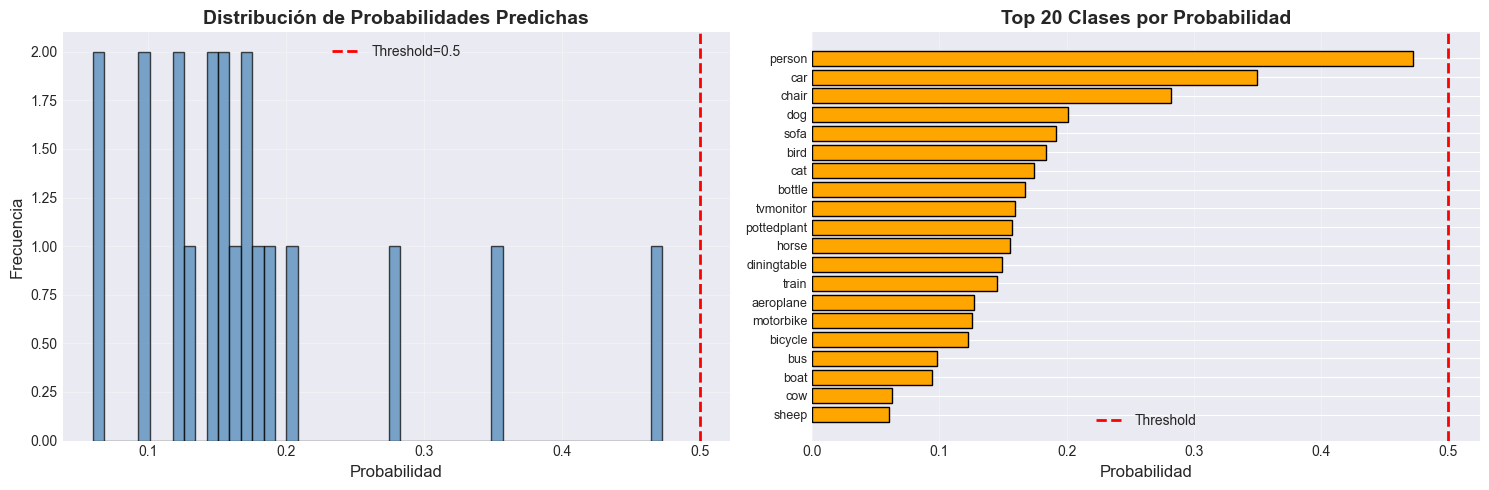


 Estadísticas de Probabilidades:

   Media: 0.1740
   Mediana: 0.1563
   Desv. estándar: 0.0948
   Máximo: 0.4725
   Mínimo: 0.0602

   Clases > 0.5: 0
   Clases > 0.7: 0
   Clases > 0.9: 0


In [12]:
# Usar primera imagen del batch de test (si existe)
if 'test_images' in locals() and len(test_images) > 0:
    sample_image = test_images[0]
else:
    # Si no hay test_images, cargar una del NPZ
    npz_file = DATA_DIR / 'voc2007_multilabel.npz'
    data = np.load(npz_file, allow_pickle=True)
    sample_image = data['images'][0].astype(np.float32) / 255.0

# Analizar distribución de probabilidades
result = predict_multilabel(
    model=model,
    img_input=sample_image,
    classes=classes,
    threshold=0.5
)

all_probs = [p['probability'] for p in result['all_predictions']]

# Visualización de distribución
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma de probabilidades
axes[0].hist(all_probs, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[0].set_xlabel('Probabilidad', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de Probabilidades Predichas', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Top 20 clases por probabilidad
top_20 = result['all_predictions'][:20]
labels_top20 = [p['class'] for p in top_20]
probs_top20 = [p['probability'] for p in top_20]
colors_top20 = ['green' if p >= 0.5 else 'orange' for p in probs_top20]

y_pos = np.arange(len(labels_top20))
axes[1].barh(y_pos, probs_top20, color=colors_top20, edgecolor='black')
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(labels_top20, fontsize=9)
axes[1].invert_yaxis()
axes[1].set_xlabel('Probabilidad', fontsize=12)
axes[1].set_title('Top 20 Clases por Probabilidad', fontsize=14, fontweight='bold')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas
print(f"\n Estadísticas de Probabilidades:\n")
print(f"   Media: {np.mean(all_probs):.4f}")
print(f"   Mediana: {np.median(all_probs):.4f}")
print(f"   Desv. estándar: {np.std(all_probs):.4f}")
print(f"   Máximo: {np.max(all_probs):.4f}")
print(f"   Mínimo: {np.min(all_probs):.4f}")
print(f"\n   Clases > 0.5: {sum(1 for p in all_probs if p >= 0.5)}")
print(f"   Clases > 0.7: {sum(1 for p in all_probs if p >= 0.7)}")
print(f"   Clases > 0.9: {sum(1 for p in all_probs if p >= 0.9)}")

---
## 12. Función para Guardar Predicciones

In [13]:
def save_predictions(predictions, output_path):
    """
    Guarda predicciones en formato JSON.
    
    Args:
        predictions: Resultado de predict_multilabel()
        output_path: Ruta donde guardar el archivo
    """
    with open(output_path, 'w') as f:
        json.dump(predictions, f, indent=2)
    print(f" Predicciones guardadas en: {output_path}")

# Ejemplo de uso
output_file = DATA_DIR / 'sample_prediction.json'
save_predictions(result, output_file)

 Predicciones guardadas en: c:\Users\mlata\Documents\iajordy2\data\voc2007\sample_prediction.json


---
## 13. Ejemplo de Predicción en Imagen Real (Si Disponible)

Probando prediccion desde archivo local:
  c:\Users\mlata\Documents\iajordy2\data\test_images\000011.jpg


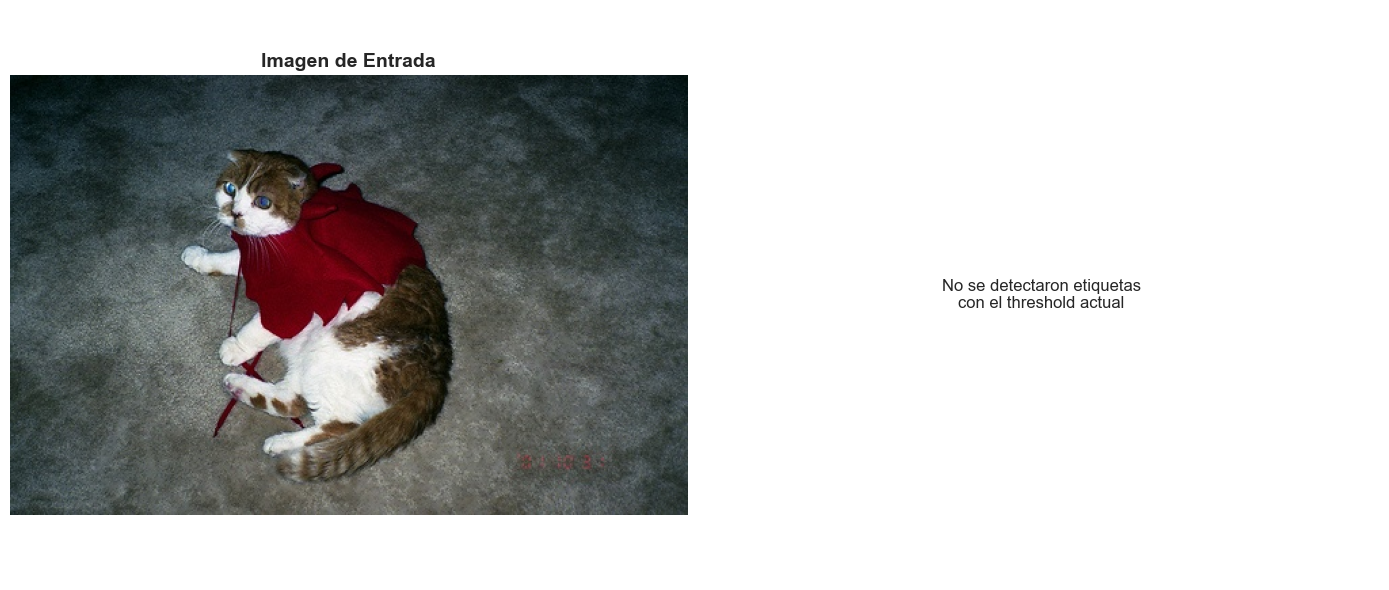


 RESULTADO DE PREDICCIÓN

Threshold utilizado: 0.5
Número de etiquetas detectadas: 0

 Etiquetas predichas:
   (Ninguna)


In [14]:
# Prediccion desde imagen local (si existe en test_images)
local_images = list(TEST_IMAGES_DIR.glob('*.jpg')) + list(TEST_IMAGES_DIR.glob('*.png'))

if len(local_images) > 0:
    sample_path = str(local_images[0])
    print(f"Probando prediccion desde archivo local:")
    print(f"  {sample_path}")
    
    try:
        result = predict_multilabel(
            model=model,
            img_input=sample_path,
            classes=classes,
            threshold=0.5,
        )
        
        visualize_prediction(sample_path, result)
    except Exception as e:
        print(f"Error: {e}")
else:
    print("No hay imagenes en data/test_images/. Agrega una imagen .jpg o .png para probar.")

---
## 14. Utilidad: Predicción desde URL o Archivo Local

In [ ]:
def predict_from_path(image_path, threshold=0.5, visualize=True):
    """
    Función completa de predicción desde ruta de archivo.
    
    Args:
        image_path: Ruta local a la imagen
        threshold: Umbral de decisión
        visualize: Si True, muestra visualización
    
    Returns:
        Resultado de predicción
    """
    # Realizar predicción
    result = predict_multilabel(
        model=model,
        img_input=image_path,
        classes=classes,
        threshold=threshold
    )
    
    # Visualizar si se solicita
    if visualize:
        visualize_prediction(image_path, result)
    
    return result

print(" Función de predicción completa definida")
print("\n Uso:")
print("   result = predict_from_path('ruta/a/imagen.jpg', threshold=0.5)")

 Función de predicción completa definida

 Uso:
   result = predict_from_path('ruta/a/imagen.jpg', threshold=0.5)


: 

---
## Resumen

### Funcionalidades:
- Carga del modelo entrenado
- Prediccion multilabel con threshold ajustable
- Soporte para imagenes desde archivos locales
- Visualizacion de resultados con graficas
- Analisis de confianza y distribucion de probabilidades

### Formato de salida:
```json
{
  "predicted_labels": ["person", "car"],
  "predictions": [
    {"class": "person", "probability": 0.92},
    {"class": "car", "probability": 0.85}
  ],
  "num_labels": 2,
  "threshold": 0.5
}
```

### Dataset: PASCAL VOC 2007
- Multilabel real con 20 categorias
- Descarga liviana
- Ideal para prediccion de multiples objetos

---
## Ejemplo de Uso

```python
# Prediccion desde archivo local
result = predict_multilabel(
    model=model,
    img_input='data/test_images/mi_imagen.jpg',
    classes=classes,
    threshold=0.5,
)

# Ver etiquetas
print(result['predicted_labels'])
```